# Sakhaa Alsaedi_157323

### Note! 


<ol>
  <li>To get the best performance, you have to train the model on 100 epochs, but in this experiment, we just run it on 1 epoch for running time-consuming.</li>
    <li>Pretrained: ImageNet</li>
    <li>Fine-tuned: Original Chest X-ray Images</li>
 
</ol>
 

## Import libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
import argparse

import random


import torch.nn.parallel
import torch.backends.cudnn as cudnn

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision
import shutil

from PIL import Image
import PIL

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Using PyTorch version 1.6.0
Random Seed:  999


In [2]:
## Evaluationg model Performnc function 

In [3]:
samples = 100
def find_scores(model, num_images=samples):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct_preds = 0
    wrong_preds = 0
    TP_0 = 0
    TP_1 = 0
    TP_2 = 0
    TN_0 = 0
    TN_1 = 0
    TN_2 = 0
    FP_0 = 0
    FP_1 = 0
    FP_2 = 0
    FN_0 = 0
    FN_1 = 0
    FN_2 = 0
    TP = 0.00001
    FP = 0.000001
    TN = 0.0000001
    FN = 0.00000001
    con01 = 0
    con02 = 0
    con10 = 0
    con12 = 0
    con20 = 0
    con21 = 0
    precision = 0
    recall = 0
    specificity = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 print(preds)
#                 print(labels)
                for k in range(3):
                    if preds[k] == labels[k]:
                        correct_preds += 1
                    elif preds[k] != labels[k]:
                        wrong_preds += 1
                    if preds[k] == 0 and labels[k] == 0:
                        TP_0 += 1
                    if preds[k] == 1 and labels[k] == 1:
                        TP_1 += 1
                    if preds[k] == 2 and labels[k] == 2:
                        TP_2 += 1
                    if preds[k] != 0 and labels[k] != 0:
                        TN_0 += 1
                    if preds[k] != 1 and labels[k] != 1:
                        TN_1 += 1
                    if preds[k] != 2 and labels[k] != 2:
                        TN_2 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_0 += 1
                    if preds[k] == 1 and labels[k] != 1:
                        FP_1 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_2 += 1
                    if preds[k] != 0 and labels[k] == 0:
                        FN_0 += 1
                    if preds[k] != 1 and labels[k] == 1:
                        FN_1 += 1
                    if preds[k] != 2 and labels[k] == 2:
                        FN_2 += 1
                    if labels[k] == 0 and preds[k] == 1:
                        con01 += 1
                    if labels[k] == 0 and preds[k] == 2:
                        con02 += 1
                    if labels[k] == 1 and preds[k] == 0:
                        con10 += 1
                    if labels[k] == 1 and preds[k] == 2:
                        con12 += 1
                    if labels[k] == 2 and preds[k] == 0:
                        con20 += 1
                    if labels[k] == 2 and preds[k] == 1:
                        con21 += 1
                    
#                 print(correct_preds)
#                 print(wrong_preds)
#                 imshow(inputs.cpu().data[j])
#             print('correct:', correct_preds/(samples*3))
#             print('wrong:', wrong_preds/(samples*3))
            
            TP = TP_0 + TP_1 + TP_2
            FP = FP_0 + FP_1 + FP_2
            TN = TN_0 + TN_1 + TN_2
            FN = FN_0 + FN_1 + FN_2
            
            confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
            
            precision = TP/(TP+FP)
            recall = TP/(TP+FN)
            specificity = TN/(FP+TN)
            
            F_score = 2*(precision*recall)/(precision+recall)
            if i == 1000:
                break
            print('precision:', precision)
            print('recall:', recall)
            print('specificity:', specificity)
            print('F_score:', F_score)
            print('==================Confusion Matrix===================')
            print(confusion)
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    confusion = 0
                    return
            
        model.train(mode=was_training)
#     confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
#         confusion = 0

# Creating Custom Dataset

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir = '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        
        def get_images(class_name):#pass class name
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')] #get list of image
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name) #get images that belong each class 
            
        self.image_dirs = image_dirs #saveing 
        self.transform = transform #saveing 
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    # the main fuction ( to make balance in the data)
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) # to avoide aout of bounds
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name) # return image, lable

In [6]:
# Just normalization for validation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(), #convert image to tensor
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize image
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])


## Original dataset

In [7]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/train/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/train/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/train/covid'
}

test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/test/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/test/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/Final_Sakhaa/Data/Original_Images/test/covid'
}

print('Training Dataset')
train_dataset = ChestXRayDataset(train_dirs, train_transform)
print('Testing Dataset')
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Training Dataset
Found 1311 normal examples
Found 1315 viral examples
Found 590 covid examples
Testing Dataset
Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


## Data loaders

In [8]:
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test)) #15*6=90


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

Number of training batches 26
Number of test batches 1


In [9]:
#Class and Lables

In [10]:

data_transforms = {
    'train': transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor(), #convert image to tensor
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize image
    ]),
    'test': transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,shuffle=True, num_workers=3)
               
              for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}

class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [11]:
class_names

['covid', 'normal', 'viral']

## Visualize original dataset

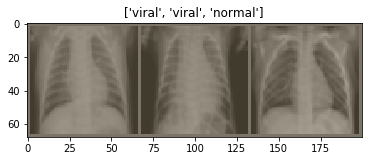

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Transfer Learning Part 

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                #phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                print(preds)
                print(labels)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the model on original images

In [15]:

model_ft = models.resnet18(pretrained=True)


## Train and evaluate


In [16]:
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(512, 3)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=100)
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

Epoch 0/0
----------



In [18]:
find_scores(model_ft)

precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[3 0 0]
 [0 3 0]
 [0 0 3]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[6 0 0]
 [0 6 0]
 [0 0 6]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[ 6  0  0]
 [ 0 15  0]
 [ 0  0  6]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[ 6  0  0]
 [ 0 15  0]
 [ 0  0 15]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[ 6  0  0]
 [ 0 18  0]
 [ 0  0 21]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[ 9  0  0]
 [ 0 21  0]
 [ 0  0 24]]
precision: 1.0
recall: 1.0
specificity: 1.0
F_score: 1.0
==================Confusion Matrix===================
[[15  0  0]
 [ 0 21

precision: 1.0
recall: 0.9513888888888888
specificity: 1.0
F_score: 0.9750889679715302
==================Confusion Matrix===================
[[ 51   0   3]
 [  0 174  18]
 [  0   0 186]]
precision: 1.0
recall: 0.9523809523809523
specificity: 1.0
F_score: 0.975609756097561
==================Confusion Matrix===================
[[ 51   0   3]
 [  0 174  18]
 [  0   0 195]]
precision: 0.993006993006993
recall: 0.9466666666666667
specificity: 0.9965870307167235
F_score: 0.969283276450512
==================Confusion Matrix===================
[[ 51   3   3]
 [  0 177  18]
 [  0   0 198]]
precision: 0.9931506849315068
recall: 0.9477124183006536
specificity: 0.9966555183946488
F_score: 0.9698996655518395
==================Confusion Matrix===================
[[ 51   3   3]
 [  0 180  18]
 [  0   0 204]]
precision: 0.9932432432432432
recall: 0.9423076923076923
specificity: 0.9967105263157895
F_score: 0.9671052631578947
==================Confusion Matrix===================
[[ 51   3   3]
 [  0 183

precision: 0.984313725490196
recall: 0.9507575757575758
specificity: 0.9922928709055877
F_score: 0.9672447013487476
==================Confusion Matrix===================
[[ 93   3   3]
 [  3 327  27]
 [  0   3 333]]
precision: 0.9844961240310077
recall: 0.951310861423221
specificity: 0.9923809523809524
F_score: 0.9676190476190475
==================Confusion Matrix===================
[[ 93   3   3]
 [  3 333  27]
 [  0   3 336]]
precision: 0.9846743295019157
recall: 0.9518518518518518
specificity: 0.992467043314501
F_score: 0.967984934086629
==================Confusion Matrix===================
[[ 96   3   3]
 [  3 336  27]
 [  0   3 339]]
precision: 0.9848484848484849
recall: 0.9523809523809523
specificity: 0.9925512104283054
F_score: 0.9683426443202979
==================Confusion Matrix===================
[[ 99   3   3]
 [  3 339  27]
 [  0   3 342]]
precision: 0.9850187265917603
recall: 0.9528985507246377
specificity: 0.992633517495396
F_score: 0.9686924493554327
==================Co

precision: 0.9865229110512129
recall: 0.953125
specificity: 0.9933774834437086
F_score: 0.9695364238410595
==================Confusion Matrix===================
[[123   6   6]
 [  3 495  36]
 [  0   3 480]]
precision: 0.9866310160427807
recall: 0.9534883720930233
specificity: 0.9934296977660972
F_score: 0.9697766097240472
==================Confusion Matrix===================
[[126   6   6]
 [  3 498  36]
 [  0   3 483]]
precision: 0.986737400530504
recall: 0.9538461538461539
specificity: 0.9934810951760105
F_score: 0.9700130378096481
==================Confusion Matrix===================
[[126   6   6]
 [  3 501  36]
 [  0   3 489]]
precision: 0.9868421052631579
recall: 0.9541984732824428
specificity: 0.9935316946959897
F_score: 0.9702457956015524
==================Confusion Matrix===================
[[126   6   6]
 [  3 507  36]
 [  0   3 492]]
precision: 0.9869451697127938
recall: 0.9545454545454546
specificity: 0.993581514762516
F_score: 0.9704749679075738
==================Confusion

precision: 0.9875776397515528
recall: 0.9578313253012049
specificity: 0.9938837920489296
F_score: 0.9724770642201834
==================Confusion Matrix===================
[[147   6   9]
 [  3 627  39]
 [  0   6 657]]
precision: 0.9876543209876543
recall: 0.9580838323353293
specificity: 0.993920972644377
F_score: 0.972644376899696
==================Confusion Matrix===================
[[147   6   9]
 [  3 633  39]
 [  0   6 660]]
precision: 0.9877049180327869
recall: 0.9563492063492064
specificity: 0.9939516129032258
F_score: 0.9717741935483871
==================Confusion Matrix===================
[[147   6   9]
 [  3 636  42]
 [  0   6 663]]
precision: 0.9877800407331976
recall: 0.9566074950690335
specificity: 0.9939879759519038
F_score: 0.9719438877755511
==================Confusion Matrix===================
[[147   6   9]
 [  3 645  42]
 [  0   6 663]]
precision: 0.9858299595141701
recall: 0.9549019607843138
specificity: 0.9930278884462151
F_score: 0.9701195219123506
=================

precision: 0.9781512605042016
recall: 0.9463414634146341
specificity: 0.9892561983471074
F_score: 0.9619834710743801
==================Confusion Matrix===================
[[168  18   9]
 [  3 804  54]
 [  0  15 774]]
precision: 0.9749582637729549
recall: 0.9449838187702265
specificity: 0.9876746096959738
F_score: 0.9597370583401809
==================Confusion Matrix===================
[[168  18   9]
 [  6 810  54]
 [  0  15 774]]
precision: 0.9750830564784053
recall: 0.9452495974235104
specificity: 0.9877350776778414
F_score: 0.9599345870809484
==================Confusion Matrix===================
[[168  18   9]
 [  6 819  54]
 [  0  15 774]]
precision: 0.9752066115702479
recall: 0.9455128205128205
specificity: 0.9877949552481693
F_score: 0.9601301871440194
==================Confusion Matrix===================
[[168  18   9]
 [  6 819  54]
 [  0  15 783]]
precision: 0.975328947368421
recall: 0.9457735247208932
specificity: 0.9878542510121457
F_score: 0.9603238866396762
================

precision: 0.9760900140646976
recall: 0.9480874316939891
specificity: 0.9882189882189882
F_score: 0.961884961884962
==================Confusion Matrix===================
[[189  21   9]
 [  6 975  60]
 [  0  18 918]]
precision: 0.9761904761904762
recall: 0.9482993197278912
specificity: 0.9882677708764666
F_score: 0.9620427881297446
==================Confusion Matrix===================
[[189  21   9]
 [  6 978  60]
 [  0  18 924]]
precision: 0.9762900976290098
recall: 0.948509485094851
specificity: 0.9883161512027492
F_score: 0.9621993127147767
==================Confusion Matrix===================
[[189  21   9]
 [  6 981  60]
 [  0  18 930]]
precision: 0.9763888888888889
recall: 0.9487179487179487
specificity: 0.9883641341546886
F_score: 0.9623545516769335
==================Confusion Matrix===================
[[192  21   9]
 [  6 984  60]
 [  0  18 933]]
precision: 0.9764868603042877
recall: 0.9489247311827957
specificity: 0.9884117246080436
F_score: 0.9625085207907295
=================

precision: 0.9768292682926829
recall: 0.9468085106382979
specificity: 0.9885954381752701
F_score: 0.9615846338535413
==================Confusion Matrix===================
[[ 237   24   15]
 [   6 1095   69]
 [   0   21 1071]]
precision: 0.976913730255164
recall: 0.9469964664310954
specificity: 0.9886363636363636
F_score: 0.9617224880382774
==================Confusion Matrix===================
[[ 240   24   15]
 [   6 1095   69]
 [   0   21 1077]]
precision: 0.9769975786924939
recall: 0.9471830985915493
specificity: 0.9886769964243146
F_score: 0.9618593563766388
==================Confusion Matrix===================
[[ 243   24   15]
 [   6 1095   69]
 [   0   21 1083]]
precision: 0.97708082026538
recall: 0.9473684210526315
specificity: 0.9887173396674585
F_score: 0.9619952494061758
==================Confusion Matrix===================
[[ 243   24   15]
 [   6 1104   69]
 [   0   21 1083]]
precision: 0.9771634615384616
recall: 0.9475524475524476
specificity: 0.9887573964497042
F_score: 0

precision: 0.973175965665236
recall: 0.9447916666666667
specificity: 0.9867864693446089
F_score: 0.9587737843551796
==================Confusion Matrix===================
[[ 273   27   21]
 [   9 1227   72]
 [   0   30 1221]]
precision: 0.9732620320855615
recall: 0.944963655244029
specificity: 0.9868282402528978
F_score: 0.9589041095890409
==================Confusion Matrix===================
[[ 276   27   21]
 [   9 1230   72]
 [   0   30 1224]]
precision: 0.9733475479744137
recall: 0.9451345755693582
specificity: 0.9868697478991597
F_score: 0.9590336134453782
==================Confusion Matrix===================
[[ 276   27   21]
 [   9 1230   72]
 [   0   30 1233]]
precision: 0.973432518597237
recall: 0.9453044375644994
specificity: 0.9869109947643979
F_score: 0.9591623036649214
==================Confusion Matrix===================
[[ 276   27   21]
 [   9 1236   72]
 [   0   30 1236]]
precision: 0.9735169491525424
recall: 0.9454732510288066
specificity: 0.9869519832985386
F_score: 0

precision: 0.9721421709894332
recall: 0.9449112978524743
specificity: 0.9862689393939394
F_score: 0.9583333333333333
==================Confusion Matrix===================
[[ 297   33   24]
 [   9 1353   75]
 [   0   36 1386]]
precision: 0.9722222222222222
recall: 0.9450651769087524
specificity: 0.9863078375826251
F_score: 0.9584513692162417
==================Confusion Matrix===================
[[ 297   33   24]
 [   9 1353   75]
 [   0   36 1395]]
precision: 0.9723018147086915
recall: 0.9452181987000928
specificity: 0.986346516007533
F_score: 0.9585687382297551
==================Confusion Matrix===================
[[ 297   33   24]
 [   9 1353   75]
 [   0   36 1404]]
precision: 0.9705042816365367
recall: 0.9444444444444444
specificity: 0.985452839042703
F_score: 0.9572970436414829
==================Confusion Matrix===================
[[ 297   33   24]
 [   9 1353   75]
 [   3   36 1410]]
precision: 0.9705882352941176
recall: 0.9445983379501385
specificity: 0.985493682732803
F_score: 0

precision: 0.972101133391456
recall: 0.94331641285956
specificity: 0.9862601975096608
F_score: 0.9574924860455131
==================Confusion Matrix===================
[[ 306   33   27]
 [   9 1476   90]
 [   3   39 1563]]
precision: 0.9721496953872933
recall: 0.9426160337552743
specificity: 0.9862896315338475
F_score: 0.9571550985432733
==================Confusion Matrix===================
[[ 306   33   27]
 [   9 1476   93]
 [   3   39 1569]]
precision: 0.9722222222222222
recall: 0.9427609427609428
specificity: 0.9863247863247864
F_score: 0.9572649572649573
==================Confusion Matrix===================
[[ 306   33   27]
 [   9 1479   93]
 [   3   39 1575]]
precision: 0.9722943722943723
recall: 0.9429051217464316
specificity: 0.9863597612958227
F_score: 0.957374254049446
==================Confusion Matrix===================
[[ 306   33   27]
 [   9 1482   93]
 [   3   39 1581]]
precision: 0.9723422644770959
recall: 0.9422110552763819
specificity: 0.9863887707358571
F_score: 0.

precision: 0.9713603818615751
recall: 0.9443155452436195
specificity: 0.9858823529411764
F_score: 0.9576470588235294
==================Confusion Matrix===================
[[ 318   36   27]
 [  12 1656   96]
 [   3   42 1689]]
precision: 0.9714285714285714
recall: 0.9444444444444444
specificity: 0.9859154929577465
F_score: 0.9577464788732395
==================Confusion Matrix===================
[[ 321   36   27]
 [  12 1662   96]
 [   3   42 1689]]
precision: 0.9714964370546318
recall: 0.9445727482678984
specificity: 0.9859484777517564
F_score: 0.9578454332552693
==================Confusion Matrix===================
[[ 327   36   27]
 [  12 1665   96]
 [   3   42 1689]]
precision: 0.9715639810426541
recall: 0.9447004608294931
specificity: 0.985981308411215
F_score: 0.9579439252336449
==================Confusion Matrix===================
[[ 327   36   27]
 [  12 1668   96]
 [   3   42 1695]]
precision: 0.9716312056737588
recall: 0.9448275862068966
specificity: 0.986013986013986
F_score: 

precision: 0.9699853587115667
recall: 0.9437321937321937
specificity: 0.9851985559566787
F_score: 0.9566787003610108
==================Confusion Matrix===================
[[ 342   36   27]
 [  18 1776  108]
 [   3   45 1857]]
precision: 0.9700511322132944
recall: 0.9438521677327647
specificity: 0.9852305475504323
F_score: 0.9567723342939481
==================Confusion Matrix===================
[[ 342   36   27]
 [  18 1779  108]
 [   3   45 1863]]
precision: 0.9693877551020408
recall: 0.9432624113475178
specificity: 0.9849029475197699
F_score: 0.9561466570812366
==================Confusion Matrix===================
[[ 342   36   27]
 [  18 1782  108]
 [   3   48 1866]]
precision: 0.9694545454545455
recall: 0.943382873319179
specificity: 0.9849354375896701
F_score: 0.9562410329985652
==================Confusion Matrix===================
[[ 342   36   27]
 [  18 1788  108]
 [   3   48 1869]]
precision: 0.969521044992743
recall: 0.943502824858757
specificity: 0.9849677881173944
F_score: 0

precision: 0.968813559322034
recall: 0.9413702239789197
specificity: 0.9846308052121617
F_score: 0.9548947544269963
==================Confusion Matrix===================
[[ 378   42   30]
 [  18 1932  120]
 [   3   54 1977]]
precision: 0.9688768606224628
recall: 0.9414858645627876
specificity: 0.9846615538512837
F_score: 0.9549849949983328
==================Confusion Matrix===================
[[ 378   42   30]
 [  18 1935  120]
 [   3   54 1983]]
precision: 0.9689399054692776
recall: 0.9416010498687664
specificity: 0.9846921797004992
F_score: 0.9550748752079867
==================Confusion Matrix===================
[[ 378   42   30]
 [  18 1935  120]
 [   3   54 1992]]
precision: 0.9683288409703504
recall: 0.9410609037328095
specificity: 0.9843905679176354
F_score: 0.9545001660577881
==================Confusion Matrix===================
[[ 378   42   30]
 [  18 1938  120]
 [   3   57 1995]]
precision: 0.968392737054472
recall: 0.9411764705882353
specificity: 0.9844216108717269
F_score: 

precision: 0.9697542533081286
recall: 0.9430147058823529
specificity: 0.9850885368126747
F_score: 0.9561975768872321
==================Confusion Matrix===================
[[ 396   42   30]
 [  18 2073  126]
 [   3   60 2148]]
precision: 0.969811320754717
recall: 0.9431192660550459
specificity: 0.9851162790697674
F_score: 0.9562790697674419
==================Confusion Matrix===================
[[ 402   42   30]
 [  18 2076  126]
 [   3   60 2148]]
precision: 0.9698681732580038
recall: 0.9432234432234432
specificity: 0.9851439182915506
F_score: 0.95636025998143
==================Confusion Matrix===================
[[ 402   42   30]
 [  18 2079  126]
 [   3   60 2154]]
precision: 0.9699248120300752
recall: 0.943327239488117
specificity: 0.9851714550509731
F_score: 0.9564411492122336
==================Confusion Matrix===================
[[ 402   42   30]
 [  18 2085  126]
 [   3   60 2157]]
precision: 0.9699812382739212
recall: 0.9434306569343066
specificity: 0.9851988899167438
F_score: 0.

precision: 0.9693215339233038
recall: 0.942627653471027
specificity: 0.9848749272833043
F_score: 0.9557882489819662
==================Confusion Matrix===================
[[ 432   42   33]
 [  18 2202  132]
 [   3   72 2295]]
precision: 0.9693757361601885
recall: 0.9427262313860252
specificity: 0.9849012775842044
F_score: 0.9558652729384437
==================Confusion Matrix===================
[[ 432   42   33]
 [  18 2211  132]
 [   3   72 2295]]
precision: 0.969429747207525
recall: 0.9428244711263579
specificity: 0.984927536231884
F_score: 0.9559420289855073
==================Confusion Matrix===================
[[ 432   42   33]
 [  18 2217  132]
 [   3   72 2298]]
precision: 0.9694835680751174
recall: 0.9429223744292238
specificity: 0.9849537037037037
F_score: 0.9560185185185186
==================Confusion Matrix===================
[[ 435   42   33]
 [  18 2217  132]
 [   3   72 2304]]
precision: 0.9695193434935522
recall: 0.9424501424501425
specificity: 0.984975440624097
F_score: 0.

precision: 0.9678313921242374
recall: 0.9396876682821755
specificity: 0.9841530054644809
F_score: 0.9535519125683061
==================Confusion Matrix===================
[[ 465   42   36]
 [  21 2349  150]
 [   3   84 2421]]
precision: 0.9678848283499446
recall: 0.9397849462365592
specificity: 0.9841789416257501
F_score: 0.9536279323513367
==================Confusion Matrix===================
[[ 465   42   36]
 [  21 2358  150]
 [   3   84 2421]]
precision: 0.9679380873410725
recall: 0.9398819108964036
specificity: 0.9842047930283224
F_score: 0.9537037037037037
==================Confusion Matrix===================
[[ 465   42   36]
 [  21 2364  150]
 [   3   84 2424]]
precision: 0.9679911699779249
recall: 0.939978563772776
specificity: 0.9842305600870038
F_score: 0.953779227841218
==================Confusion Matrix===================
[[ 465   42   36]
 [  21 2370  150]
 [   3   84 2427]]
precision: 0.9680440771349862
recall: 0.9400749063670412
specificity: 0.9842562432138979
F_score: 

precision: 0.9691099476439791
recall: 0.9405487804878049
specificity: 0.984785972150593
F_score: 0.9546157813305827
==================Confusion Matrix===================
[[ 495   45   39]
 [  21 2514  159]
 [   3   84 2544]]
precision: 0.9686356508102457
recall: 0.9401319127346525
specificity: 0.984552008238929
F_score: 0.9541709577754892
==================Confusion Matrix===================
[[ 495   45   39]
 [  21 2514  159]
 [   3   87 2550]]
precision: 0.9686847599164927
recall: 0.9402228976697061
specificity: 0.9845758354755784
F_score: 0.9542416452442158
==================Confusion Matrix===================
[[ 498   45   39]
 [  21 2517  159]
 [   3   87 2553]]
precision: 0.9687337154768109
recall: 0.9403136064744563
specificity: 0.9845995893223819
F_score: 0.9543121149897331
==================Confusion Matrix===================
[[ 498   45   39]
 [  21 2520  159]
 [   3   87 2559]]
precision: 0.9687825182101977
recall: 0.9404040404040404
specificity: 0.9846232701178883
F_score: 

precision: 0.9692917285785042
recall: 0.9399615754082613
specificity: 0.9848817361619118
F_score: 0.9544013655206047
==================Confusion Matrix===================
[[ 516   45   45]
 [  24 2637  171]
 [   3   87 2718]]
precision: 0.9693221177634834
recall: 0.939568345323741
specificity: 0.9849001461276181
F_score: 0.9542133463224549
==================Confusion Matrix===================
[[ 516   45   48]
 [  24 2640  171]
 [   3   87 2721]]
precision: 0.9693675889328063
recall: 0.9396551724137931
specificity: 0.9849221789883269
F_score: 0.9542801556420234
==================Confusion Matrix===================
[[ 516   45   48]
 [  24 2643  171]
 [   3   87 2727]]
precision: 0.9694129255056734
recall: 0.93974175035868
specificity: 0.9849441476444876
F_score: 0.9543467702768333
==================Confusion Matrix===================
[[ 519   45   48]
 [  24 2646  171]
 [   3   87 2730]]
precision: 0.9694581280788177
recall: 0.9398280802292264
specificity: 0.9849660523763336
F_score: 0

precision: 0.9694692343823391
recall: 0.9411764705882353
specificity: 0.9849606663581675
F_score: 0.955113373438223
==================Confusion Matrix===================
[[ 537   45   48]
 [  27 2793  174]
 [   3   90 2862]]
precision: 0.9695121951219512
recall: 0.9412568306010929
specificity: 0.984981515711645
F_score: 0.9551756007393716
==================Confusion Matrix===================
[[ 540   45   48]
 [  27 2796  174]
 [   3   90 2865]]
precision: 0.9695550351288056
recall: 0.9413369713506139
specificity: 0.9850023073373327
F_score: 0.9552376557452699
==================Confusion Matrix===================
[[ 543   45   48]
 [  27 2802  174]
 [   3   90 2865]]
precision: 0.9695977549111319
recall: 0.94141689373297
specificity: 0.9850230414746544
F_score: 0.9552995391705069
==================Confusion Matrix===================
[[ 543   45   48]
 [  27 2805  174]
 [   3   90 2871]]
precision: 0.9696403549743111
recall: 0.9414965986394558
specificity: 0.9850437183617119
F_score: 0.

precision: 0.9700892857142858
recall: 0.9431423611111112
specificity: 0.9852552816901409
F_score: 0.9564260563380282
==================Confusion Matrix===================
[[ 555   48   48]
 [  27 2952  174]
 [   3   93 3012]]
precision: 0.9701292911279537
recall: 0.9432162982228002
specificity: 0.9852747252747253
F_score: 0.9564835164835165
==================Confusion Matrix===================
[[ 558   48   48]
 [  27 2955  174]
 [   3   93 3015]]
precision: 0.9697239536954586
recall: 0.9428571428571428
specificity: 0.9850746268656716
F_score: 0.9561018437225637
==================Confusion Matrix===================
[[ 561   48   48]
 [  27 2955  174]
 [   3   96 3018]]
precision: 0.9697643397065362
recall: 0.9429312581063554
specificity: 0.9850942569048663
F_score: 0.9561595791319597
==================Confusion Matrix===================
[[ 561   48   48]
 [  27 2958  174]
 [   3   96 3024]]
precision: 0.9698046181172292
recall: 0.9430051813471503
specificity: 0.9851138353765324
F_score

precision: 0.969838572642311
recall: 0.9441687344913151
specificity: 0.9851215423302598
F_score: 0.9568315171835708
==================Confusion Matrix===================
[[ 600   48   48]
 [  27 3096  174]
 [   3  105 3153]]
precision: 0.9698769622401358
recall: 0.9442379182156134
specificity: 0.9851402260359984
F_score: 0.9568857262452909
==================Confusion Matrix===================
[[ 600   48   48]
 [  27 3099  174]
 [   3  105 3159]]
precision: 0.9699152542372881
recall: 0.9443069306930693
specificity: 0.9851588628762542
F_score: 0.9569397993311036
==================Confusion Matrix===================
[[ 600   48   48]
 [  27 3105  174]
 [   3  105 3162]]
precision: 0.9699534490055015
recall: 0.9443757725587144
specificity: 0.9851774530271399
F_score: 0.9569937369519834
==================Confusion Matrix===================
[[ 600   48   48]
 [  27 3108  174]
 [   3  105 3168]]
precision: 0.9699915469146239
recall: 0.9444444444444444
specificity: 0.9851959966638866
F_score:

precision: 0.9703372612759041
recall: 0.9442467378410438
specificity: 0.9853707414829659
F_score: 0.9571142284569139
==================Confusion Matrix===================
[[ 633   51   48]
 [  27 3234  186]
 [   3  108 3297]]
precision: 0.9703733766233766
recall: 0.9443127962085308
specificity: 0.9853883106485188
F_score: 0.9571657325860687
==================Confusion Matrix===================
[[ 636   51   48]
 [  27 3240  186]
 [   3  108 3297]]
precision: 0.9704094041345764
recall: 0.9443786982248521
specificity: 0.9854058376649341
F_score: 0.9572171131547381
==================Confusion Matrix===================
[[ 639   51   48]
 [  27 3243  186]
 [   3  108 3300]]
precision: 0.9704333738355609
recall: 0.9440504334121356
specificity: 0.9854204114240064
F_score: 0.9570601158378271
==================Confusion Matrix===================
[[ 639   51   48]
 [  27 3249  189]
 [   3  108 3300]]
precision: 0.9704692556634305
recall: 0.944116489571035
specificity: 0.9854378615599442
F_score:

precision: 0.9697087378640776
recall: 0.9447597427166099
specificity: 0.9850517439632043
F_score: 0.9570716749712532
==================Confusion Matrix===================
[[ 666   54   48]
 [  30 3399  189]
 [   3  114 3426]]
precision: 0.969732246798603
recall: 0.9444444444444444
specificity: 0.9850660539919587
F_score: 0.9569213095921884
==================Confusion Matrix===================
[[ 666   54   48]
 [  30 3405  192]
 [   3  114 3426]]
precision: 0.9697674418604652
recall: 0.9445073612684032
specificity: 0.985083189902467
F_score: 0.9569707401032702
==================Confusion Matrix===================
[[ 669   54   48]
 [  30 3408  192]
 [   3  114 3429]]
precision: 0.9698025551684089
recall: 0.9445701357466063
specificity: 0.9851002865329513
F_score: 0.9570200573065903
==================Confusion Matrix===================
[[ 675   54   48]
 [  30 3411  192]
 [   3  114 3429]]
precision: 0.9698375870069605
recall: 0.9446327683615819
specificity: 0.9851173440183171
F_score: 

precision: 0.9687267311988086
recall: 0.9437794704388829
specificity: 0.9845673341907036
F_score: 0.9560903913283115
==================Confusion Matrix===================
[[ 693   57   51]
 [  36 3561  201]
 [   3  117 3552]]
precision: 0.9687616214206024
recall: 0.9438405797101449
specificity: 0.9845843273995228
F_score: 0.9561387410534042
==================Confusion Matrix===================
[[ 693   57   51]
 [  36 3561  201]
 [   3  117 3561]]
precision: 0.9687848383500557
recall: 0.9435396308360477
specificity: 0.9845984598459846
F_score: 0.955995599559956
==================Confusion Matrix===================
[[ 693   57   51]
 [  36 3564  204]
 [   3  117 3564]]
precision: 0.9688195991091314
recall: 0.9436008676789588
specificity: 0.9846153846153847
F_score: 0.956043956043956
==================Confusion Matrix===================
[[ 693   57   51]
 [  36 3573  204]
 [   3  117 3564]]
precision: 0.9688542825361512
recall: 0.9436619718309859
specificity: 0.9846322722283205
F_score: 

precision: 0.9673951988534576
recall: 0.9414225941422594
specificity: 0.9839194203922954
F_score: 0.9542321965011485
==================Confusion Matrix===================
[[ 717   60   54]
 [  39 3708  219]
 [   3  129 3675]]
precision: 0.9674302075876879
recall: 0.9414838035527691
specificity: 0.9839364518976169
F_score: 0.9542806707855251
==================Confusion Matrix===================
[[ 717   60   54]
 [  39 3711  219]
 [   3  129 3681]]
precision: 0.9674651412227386
recall: 0.941544885177453
specificity: 0.9839534473637807
F_score: 0.9543290424969141
==================Confusion Matrix===================
[[ 717   60   54]
 [  39 3714  219]
 [   3  129 3687]]
precision: 0.9675
recall: 0.9416058394160584
specificity: 0.9839704069050554
F_score: 0.9543773119605425
==================Confusion Matrix===================
[[ 720   60   54]
 [  39 3717  219]
 [   3  129 3690]]
precision: 0.9675347841598287
recall: 0.9416666666666667
specificity: 0.9839873306352279
F_score: 0.954425479

precision: 0.9675973802137194
recall: 0.9413145539906104
specificity: 0.9840217576066632
F_score: 0.954275029746728
==================Confusion Matrix===================
[[ 741   60   60]
 [  39 3840  225]
 [   3  138 3840]]
precision: 0.9676308539944903
recall: 0.9413735343383585
specificity: 0.9840380370181695
F_score: 0.9543216165732721
==================Confusion Matrix===================
[[ 741   60   60]
 [  39 3846  225]
 [   3  138 3843]]
precision: 0.9676642586859305
recall: 0.9414323962516734
specificity: 0.9840542832909245
F_score: 0.9543681085665818
==================Confusion Matrix===================
[[ 741   60   60]
 [  39 3855  225]
 [   3  138 3843]]
precision: 0.9676975945017182
recall: 0.9414911400869275
specificity: 0.9840704965260125
F_score: 0.9544145060159294
==================Confusion Matrix===================
[[ 744   60   60]
 [  39 3855  225]
 [   3  138 3849]]
precision: 0.9677197802197802
recall: 0.9412157648630595
specificity: 0.984083982390789
F_score: 

tensor([2, 2, 2])
tensor([2, 2, 2])


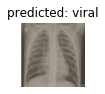

tensor([2, 2, 2])
tensor([2, 2, 2])


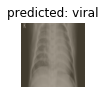

tensor([2, 2, 2])
tensor([2, 2, 2])


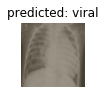

tensor([1, 1, 2])
tensor([1, 1, 2])


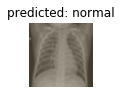

tensor([1, 1, 2])
tensor([1, 1, 2])


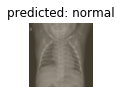

tensor([1, 1, 2])
tensor([1, 1, 2])


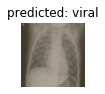

In [19]:
visualize_model(model_ft)